# Imports

In [1]:
import torch 
import numpy 
import matplotlib
import matplotlib.pyplot as plt
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator
import torch_geometric 
import myutils
import models
#from models import SAGE,DotProductLinkPredictor
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.utils import negative_sampling
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dataset_name='ogbl-ddi'
dataset=PygLinkPropPredDataset(name=dataset_name)
data=dataset[0]
adj_t=PygLinkPropPredDataset(name=dataset_name,transform=torch_geometric.transforms.ToSparseTensor('coo'))[0].adj_t.to(device)






cpu


c:\Users\pchrk\OneDrive\Desktop\pms cs\NLP\NLP\nlp_venv\lib\site-packages\torch_geometric\utils\sparse.py:176: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ..\aten\src\ATen\SparseCsrTensorImpl.cpp:56.)
  return adj.to_sparse_csr()


In [2]:
initial_embeddings=torch.ones(data.num_nodes, 1).to(device=device)
split_edge=dataset.get_edge_split()

In [3]:
# Initialize our model and LinkPredictor
hidden_dimension = 256
model = models.SAGE(1, hidden_dimension, hidden_dimension, 7, 0.5).to(device)
predictor = models.DotProductLinkPredictor().to(device)

# Run our initial "node features" through the GNN to get node embeddings
model.eval()
predictor.eval()
h = model(initial_embeddings, adj_t)

# Randomly sample some training edges and pass them through our basic predictor
torch.manual_seed(1955)
idx = torch.randperm(split_edge['train']['edge'].size(0))[:10]
edges = split_edge['train']['edge'][idx].t()
predictor(h[edges[0]], h[edges[1]])

tensor([0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7311, 0.7310, 0.7311, 0.7311,
        0.7311], grad_fn=<SigmoidBackward0>)

In [4]:
def create_train_batch(all_pos_train_edges,perm,edge_index):
    pos_edges=all_pos_train_edges[perm].t().to(device)

    #produce as many negative edges as positive edges
    neg_edges=negative_sampling(edge_index, num_neg_samples=perm.shape[0], method='dense').to(device)
    training_edges=torch.cat([pos_edges, neg_edges], dim=1)

    pos_labels=torch.ones(pos_edges.shape[1], dtype=torch.float, device=device)
    neg_labels=torch.zeros(neg_edges.shape[1], dtype=torch.float, device=device)

    training_labels=torch.cat([pos_labels, neg_labels], dim=0).to(device)

    return training_edges, training_labels

Example of a training batch of size 64 produces a training batch with size 128--> produces 64 real edges and 64 fake edges (total 64 training examples)
src_edges= [1 X 128]-->64 real and 64 fake edges of source
dest_edges=[1 X 128]--> 64 real and 64 fake destinations

training edges=[src_edges,
                dest_edges]= [ 2 X 
                                [1 X 128]
                                ]

training_labels=[1 X 128] 64 ones and 64 zeroes

In [5]:
batch_size=64
create_train_batch(split_edge['train']['edge'],torch.randperm(n=split_edge['train']['edge'].size(0))[:batch_size],data.edge_index)[0][0]

tensor([ 330,  336,  522, 1778,  259,  894, 2503,  106,  558, 1361,  216, 1816,
         353, 2127, 3972, 3887, 2484, 3089,  993,   68, 2429, 2595,   37,  631,
          38, 3254, 2875,  395, 2782,  292, 3606, 3498, 1004, 2211, 4112,  523,
         224, 3312, 2492, 3957, 3792,  924, 2986, 2091,  159, 4002, 1666, 2858,
        2955, 3374,  212, 1010, 1295, 3478,  945,  195, 2861, 3865, 4000,  868,
        3946, 3532, 4039,  505, 3776, 2041,  758,  775, 4007, 1552, 2615, 1041,
         588, 1043, 3469,  894, 1556, 3648, 3426, 2858, 2480, 3693, 3738,  618,
          75,  142, 2549, 2957,  862, 2542, 4192, 1725, 3378, 2185, 1789, 1440,
        3592, 2460,   18, 3694, 1849, 1432, 3974, 4209,  987, 1525,  129, 2222,
        2511,  157, 2311, 2041, 1805,  513,  139,  321, 4228, 3185, 4046, 2754,
         197, 3508, 3559, 2487, 2425, 3350, 2878,  130])

In [6]:
def train(model, predictor, x, adj_t, split_edge, loss_fn, optimizer, batch_size, num_epochs):
  # adj_t isn't used everywhere in PyG yet, so we switch back to edge_index for negative sampling
  # row, col, edge_attr = adj_t.t().coo()
  # edge_index = torch.stack([row, col], dim=0)

  edge_index=PygLinkPropPredDataset(name='ogbl-ddi')[0].edge_index.to(device)
  model.train()
  predictor.train()

  model.reset_parameters()
  predictor.reset_parameters()
  loss_per_epoch = []
  all_pos_train_edges = split_edge['train']['edge']
  for epoch in range(num_epochs):
    epoch_total_loss = 0
    for perm in DataLoader(range(all_pos_train_edges.shape[0]), batch_size,
                           shuffle=True):
      optimizer.zero_grad()

      train_edge, train_label = create_train_batch(all_pos_train_edges, perm, edge_index)


      h = model(x, adj_t)

      # Get predictions for our batch and compute the loss
      preds = predictor(h[train_edge[0]], h[train_edge[1]])
      loss = loss_fn(preds, train_label)

      epoch_total_loss += loss.item()

      # Update our parameters
      # pass the loss of the current training batch backwards
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
      optimizer.step()
    loss_per_epoch.append(epoch_total_loss)
    myutils.draw_metric_per_epoch(loss_per_epoch, "Loss per epoch", "Loss", "Epoch", "loss_per_epoch")
    print(f'Epoch {epoch} has loss {round(epoch_total_loss, 4)}')

In [7]:

#turn off gradient tracking for test
@torch.no_grad()
def test(model, predictor, x, adj_t, split_edge, evaluator, batch_size):
    model.eval()
    predictor.eval()

    
    h = model(x, adj_t)

    pos_eval_edge = split_edge['edge'].to(device)
    neg_eval_edge = split_edge['edge_neg'].to(device)

    pos_eval_preds = []
    for perm in DataLoader(range(pos_eval_edge.shape[0]), batch_size):
        edge = pos_eval_edge[perm].t()
        pos_eval_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_eval_pred = torch.cat(pos_eval_preds, dim=0)

    neg_eval_preds = []
    for perm in DataLoader(range(neg_eval_edge.size(0)), batch_size):
        edge = neg_eval_edge[perm].t()
        neg_eval_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_eval_pred = torch.cat(neg_eval_preds, dim=0)

    total_preds = torch.cat((pos_eval_pred, neg_eval_pred), dim=0)
    labels = torch.cat((torch.ones_like(pos_eval_pred), torch.zeros_like(neg_eval_pred)), dim=0)
    acc = models.BinaryAccuracy(total_preds, labels)

    results = {}
    for K in [10, 20, 30, 40, 50]:
        evaluator.K = K
        valid_hits = evaluator.eval({
            'y_pred_pos': pos_eval_pred,
            'y_pred_neg': neg_eval_pred,
        })[f'hits@{K}']
        results[f'Hits@{K}'] = (valid_hits)
    results['Accuracy'] = acc

    return results
eval = Evaluator(name='ogbl-ddi')
# ogb Evaluators can be invoked to get their expected format
print(eval.expected_input_format) 

==== Expected input format of Evaluator for ogbl-ddi
{'y_pred_pos': y_pred_pos, 'y_pred_neg': y_pred_neg}
- y_pred_pos: numpy ndarray or torch tensor of shape (num_edges, ). Torch tensor on GPU is recommended for efficiency.
- y_pred_neg: numpy ndarray or torch tensor of shape (num_edges, ). Torch tensor on GPU is recommended for efficiency.
y_pred_pos is the predicted scores for positive edges.
y_pred_neg is the predicted scores for negative edges.
Note: As the evaluation metric is ranking-based, the predicted scores need to be different for different edges.


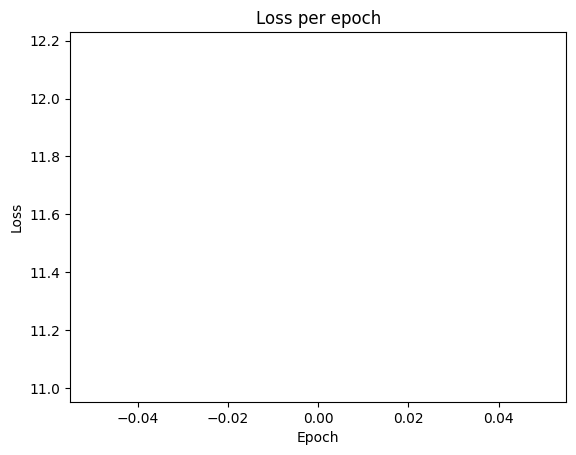

Epoch 0 has loss 11.5915


KeyboardInterrupt: 

In [9]:
# SAGE AND CONCAT NEURAL LINK PREDICTOR
# Initialize our model and LinkPredictor
hidden_dimension = 256
model = models.SAGE(1, hidden_dimension, hidden_dimension, 7, 0.5).to(device)
predictor = models.ConcatNeuralLinkPredictor(hidden_dimension,hidden_dimension,1,4,0.5).to(device)

# Run our initial "node features" through the GNN to get node embeddings
model.eval()
predictor.eval()
h = model(initial_embeddings, adj_t)


# SAGE AND neural LINK PREDICTOR
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.01)
train(model, predictor, initial_embeddings, adj_t, split_edge, torch.nn.BCELoss(), 
      optimizer, 64*1024, 10)
test(model, predictor, initial_embeddings, adj_t, split_edge["valid"], Evaluator(name='ogbl-ddi'), 64*1024)

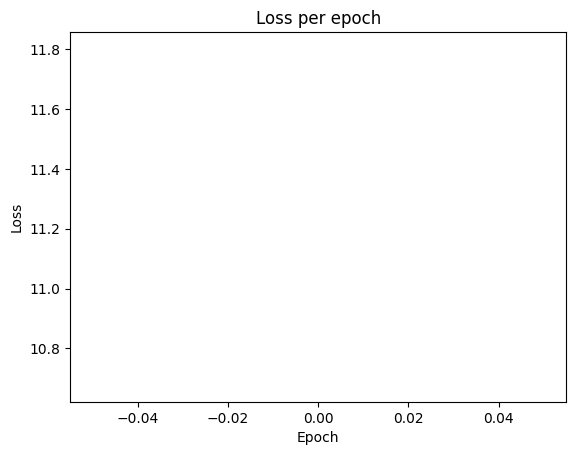

Epoch 0 has loss 11.2395


KeyboardInterrupt: 

In [ ]:
# SAGE AND NEURAL LINK PREDICTOR
# Initialize our model and LinkPredictor
hidden_dimension = 256
model = models.SAGE(1, hidden_dimension, hidden_dimension, 7, 0.5).to(device)
predictor = models.NeuralLinkPredictor(hidden_dimension,hidden_dimension,1,4,0.5).to(device)

# Run our initial "node features" through the GNN to get node embeddings
model.eval()
predictor.eval()
h = model(initial_embeddings, adj_t)


# SAGE AND neural LINK PREDICTOR
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.01)
train(model, predictor, initial_embeddings, adj_t, split_edge, torch.nn.BCELoss(), 
      optimizer, 64*1024, 10)
test(model, predictor, initial_embeddings, adj_t, split_edge["valid"], Evaluator(name='ogbl-ddi'), 64*1024)


In [ ]:
# SAGE AND DOT LINK PREDICTOR
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.01)
train(model, predictor, initial_embeddings, adj_t, split_edge, torch.nn.BCELoss(), 
      optimizer, 64*1024, 5)
test(model, predictor, initial_embeddings, adj_t, split_edge["valid"], Evaluator(name='ogbl-ddi'), 64*1024)

KeyboardInterrupt: 